In [3]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
sys.path.append(
    os.path.join(
        os.getcwd(),
        'LADOTD Data',
        )
    )

from document_cleaner import DocumentCleaner

In [6]:
data_raw = pd.read_csv('./LADOTD Data/road_closures_train.csv')
data_raw.shape

(678, 3)

---

Exploratory data analysis on manually labeled updates:

In [7]:
data_raw['closed'].value_counts().index

Float64Index([1.0, -1.0, 0.0], dtype='float64')

Bar plot of distributions from the labeled updates

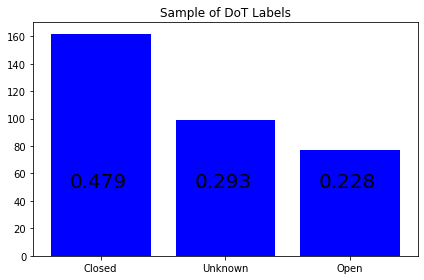

In [8]:
plt.bar(
    data_raw['closed'].value_counts().index.astype(str), 
    data_raw['closed'].value_counts().values,
    color='blue',
    )
plt.xticks(data_raw['closed'].value_counts().index.astype(str), ['Closed', 'Unknown', 'Open'])

plt.annotate(round(data_raw['closed'].value_counts(normalize=True).values[0], 3), (0-0.25,50), fontsize=20)
plt.annotate(round(data_raw['closed'].value_counts(normalize=True).values[1], 3), (1-0.25,50), fontsize=20)
plt.annotate(round(data_raw['closed'].value_counts(normalize=True).values[2], 3), (2-0.25,50), fontsize=20)

plt.title('Sample of DoT Labels')
plt.tight_layout()

Create a clean corpus for training

In [9]:
corpus_train = data_raw[['closed', 'report']].dropna(axis=0).copy(deep=True)
corpus_train['closed'] = corpus_train['closed'].astype(int)

X = corpus_train['report'].values
y = corpus_train['closed'].values

corpus_train.shape

(338, 2)

In [10]:
corpus_test = data_raw[['closed', 'report']].copy(deep=True)
corpus_test.shape

(678, 2)

In [11]:
corpus_train['closed'].value_counts(normalize=True)

 1    0.479290
-1    0.292899
 0    0.227811
Name: closed, dtype: float64

---

Build pipeline to test different models (Naive Bayes, Gradient Boosted Trees, and Linear SVC). Include a self-made class for cleaning to allow robust use of the pickled model pipeline

In [12]:
#classifier = MultinomialNB()
classifier = GradientBoostingClassifier()
#classifier = LinearSVC(loss='squared_hinge', C=1.0, tol=1e-3)

model = Pipeline([
    ('clean', DocumentCleaner()),
    ('cv', CountVectorizer(max_features=1000, ngram_range=(1,3), stop_words='english')),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', classifier),
    ])

Train the model on only labeled data

In [13]:
model.fit(X, y)
y_hat = model.predict(X)

Total accuracy:

In [14]:
corpus_train['pred'] = y_hat
np.mean(y==y_hat)

0.9970414201183432

Accuracy of road closed updates:

In [15]:
np.mean(
    corpus_train[corpus_train['closed']==1]['closed'] == corpus_train[corpus_train['closed']==1]['pred']
    )

1.0

Accuracy of road open updates:

In [16]:
np.mean(
    corpus_train[corpus_train['closed']==0]['closed'] == corpus_train[corpus_train['closed']==0]['pred']
    )

0.987012987012987

Accuracy of unknown updates:

In [17]:
np.mean(
    corpus_train[corpus_train['closed']==-1]['closed'] == corpus_train[corpus_train['closed']==-1]['pred']
    )

1.0

Predict on all updates and inspect performance

In [18]:
corpus_test['pred'] = model.predict(corpus_test['report'])
corpus_test[['report', 'pred']].values[100:103]

array([['I-10 EB (EAST BATON ROUGE PARISH) MM 167 TO MM169', -1],
       ['I-10 WB (EAST BATON ROUGE PARISH) MM 168 TO MM 166', -1],
       ['UPDATE - LANE/SHOULDER CLOSURES: I-20/I-220 Interchange, Bossier Parish',
        1]], dtype=object)

---

Pickle the model

In [19]:
with open('./LADOTD Data/closed_clf.pkl', 'wb') as f:
    pickle.dump(model, f)

Check if pickle works:

In [20]:
with open('./LADOTD Data/closed_clf.pkl', 'rb') as f:
    clf = pickle.load(f)

In [21]:
clf.predict(['UPDATE - LANE/SHOULDER CLOSURES: I-20/I-220 Interchange, Bossier Parish'])

array([1])